Here execute a Corona algorithm so that we may compare its accuracy to the that of a neural network

In [2]:
%matplotlib inline
import copy
import numpy as np
import tables as tb
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse


data_filename = 'TMC_data.h'


/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Load SiPM maps

In [3]:
f = tb.open_file('TMC_data.h','r')


data = f.root.sim_1pt
maps   = data.xvalid[:]

for m in maps:
    m -= np.min(m) # make minimum=0 (min is negative)
    
example = np.random.randint(0,maps.shape[0])
test = maps[example].reshape((8,8)).T
real_coords = data.yvalid[:]

In [4]:
maxes = []
for m in maps: 
    maxes.append(np.max(m))

example = np.random.randint(0,maps.shape[0])
test = maps[example].reshape((8,8)).T

real_coords = data.yvalid[:]
#maxes = np.array(maxes)
#print(np.min(maxes))

coords = []
def corona(m,coords):
    """
    corona takes as input a map
    outputs a list of tuples, each tuple contains the coordinates of a EL hit
    """
    x=0
    y=0
    hit_energy = 0 
    mt = copy.deepcopy(m)
    (xi,yi) = np.unravel_index(mt.argmax(), mt.shape)

    if mt[xi,yi] > 4.1:
        
        for h in range(-3,4):
            for v in range(-3,4):
                try: 
                    x += (xi+h) * mt[xi+h,yi+v]
                    y += (yi+v) * mt[xi+h,yi+v]
                    hit_energy += mt[xi+h,yi+v]
                    mt[xi+h,yi+v] = 0

                except: pass
            
        x /= hit_energy
        y /= hit_energy
        
        coords.append((x,y))
        corona(mt,coords)
        
    else: return
    return

corona(test,coords)
print(np.array(coords)*10+5)
print(real_coords[example]*80)



[[ 6.24890123  7.65669503]]
[ 4.90822413  7.51937155]


Mean error with 1 hit (mm): 1.32040401012
(10000,)


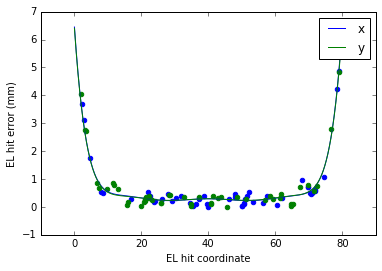

In [32]:
E  = np.empty((maps.shape[0]))
rd = np.empty((maps.shape[0]))
xe = np.empty((maps.shape[0]))
xc = np.empty((maps.shape[0]))
ye = np.empty((maps.shape[0]))
yc = np.empty((maps.shape[0]))


e = 0
for m,c in zip(maps,real_coords):
    coords =[]
    m    = m.reshape((8,8)).T
    corona(m,coords)
    E[e] = np.sqrt(np.sum(((np.array(coords[0]))*10+5 - c*80)**2))
    #if E[e] > 1 : print(coords[0],c)
    rd[e] = np.sqrt(np.sum((np.array([40,40] - c*80))**2))
    xe[e] = abs(coords[0][0]*10+5 - c[0]*80)
    xc[e] = c[0]*80
    ye[e] = abs(coords[0][1]*10+5 - c[1]*80)
    yc[e] = c[1]*80
    
    e += 1
    
    
print('Mean error with 1 hit (mm): ' + str(np.mean(E)))

# Error as a function radial distance from center
#bestfit = plt.plot(np.unique(rd), np.poly1d(np.polyfit(rd,E, 5))(np.unique(rd)))
#plt.scatter(rd[0:100],E[0:100])

# x, y error as a function of x, y  EL hit coordinate
plt.scatter(xc[0:50],xe[0:50],color='b') # sample points
plt.scatter(yc[0:50],ye[0:50],color='g') # sample points
bestfitx = plt.plot(np.unique(xc), np.poly1d(np.polyfit(xc,xe, 8))(np.unique(xc)),label='x')
bestfity = plt.plot(np.unique(yc), np.poly1d(np.polyfit(yc,ye, 8))(np.unique(yc)),label='y')
plt.legend(loc='upper right')
plt.xlabel('EL hit coordinate')
plt.ylabel('EL hit error (mm)')
plt.show()